<a href="https://colab.research.google.com/github/harsh-agar/E-Net/blob/master/CNN%2BXGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import layers, models, Input
# from tensorflow.keras impor14t datasets, layers, models
import matplotlib.pyplot as plt

In [0]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import tensorflow as tf
from tqdm import tqdm
# Allow image embeding in notebook
%matplotlib inline
import time
import cv2

In [0]:
import matplotlib.image as mpimg
from PIL import Image

In [0]:
def read_saved_model(model_name):
  yaml_file_name = '/content/gdrive/My Drive/Pothole_images/models/%s.yaml' %(model_name)
  yaml_file = open(yaml_file_name, 'r')
  loaded_model_yaml = yaml_file.read()
  yaml_file.close()
  loaded_model = model_from_yaml(loaded_model_yaml)
  # load weights into new model
  h5_file_name = '/content/gdrive/My Drive/Pothole_images/models/%s.h5' %(model_name)
  loaded_model.load_weights(h5_file_name)
  print("Loaded model %s from disk" % (model_name))

  loaded_model.compile(optimizer=Adam(lr=0.001), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])
  return loaded_model

In [0]:
from skimage import data

def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    start = time.time()
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    index = []
    c = 0
    labels_dict = {'Potholes': 0, 'Crack': 1, 'Good_Roads': 2}
    
    for d in tqdm(directories):
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.lower().endswith(".ppm") or f.lower().endswith(".jpg")
                      or f.lower().endswith(".png") or f.lower().endswith(".jpeg") or f.lower().endswith(".heic")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            # image = data.imread(f)
            try:
              image = cv2.imread(f)
              images.append(image)
              # images.append(skimage.transform.resize(image, (128, 128), mode='constant'))
              labels.append(int(labels_dict[d]))
              # index.append(int(c))
              # c = c+1
            except:
              continue
            # print(c)
    end = time.time()
    print(end - start)
    # return images, labels, index 
    return images, labels

In [0]:
def display_images_and_labels(images, labels, inv_dict):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(10, 10))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)+2]
        plt.subplot(1, max(labels)+1, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        # label_name = 'Potholes'
        # for label_key, val in labels_dict.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
            # if val == search_age:
        label_name = inv_dict[label]
        # if label==1:
        #     label_name = 'Crack'
        plt.title("{0} ({1})".format(label_name, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted \naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
labels_dict = {'Potholes': 0, 'Crack': 1, 'Good_Roads': 2}
labels_dict_inv = ['Potholes', 'Crack', 'Good_Roads']

In [12]:
# train_data_dir = r"/content/gdrive/My Drive/Pothole_images/Training"
# test_data_dir = r"/content/gdrive/My Drive/Pothole_images/Validation"
data_dir = '/content/gdrive/My Drive/Pothole_images/merged_data'

# train_images32, train_labels32 = load_data(train_data_dir)
# test_1images32, test_labels32 = load_data(test_data_dir)
data_images32, data_labels32 = load_data(data_dir)

100%|██████████| 4/4 [10:26<00:00, 156.63s/it]

626.773234128952


In [14]:
print (len(data_images32))
print (len(data_labels32))

2762
2762


In [0]:
for i in range(len(data_images32)):
  if(len(data_images32[i].shape)!=3):
    data_images32[i] = np.stack((data_images32[i],)*3, axis=-1)
    # print(train_images32[i].shape)
    # print(i)

In [0]:
train_images32 = []
train_labels32 = []
test_images32 = []
test_labels32 = []

val_precentage = 20
val_img_num = (100/val_precentage)

for i in range(len(data_images32)):
  if i%val_img_num==0:
    test_images32.append(data_images32[i])
    test_labels32.append(data_labels32[i])
  else:
    train_images32.append(data_images32[i])
    train_labels32.append(data_labels32[i])

In [17]:
print (len(train_images32))
print (len(train_labels32))
print (len(test_images32))
print (len(test_labels32))

2209
2209
553
553


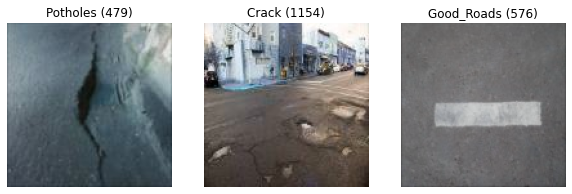

In [18]:
display_images_and_labels(train_images32, train_labels32, labels_dict_inv)

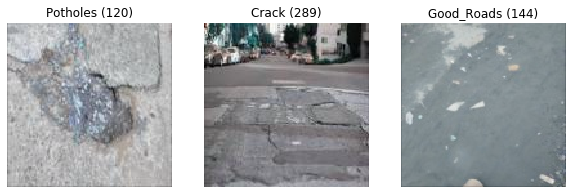

In [0]:
display_images_and_labels(test_images32, test_labels32, labels_dict_inv)

In [19]:
train_labels_np = np.array(train_labels32)
test_labels_np = np.array(test_labels32)
train_images32_np = np.array(train_images32)
test_images32_np = np.array(test_images32)

print(train_images32_np.shape)
print(test_images32_np.shape)
print(train_labels_np.shape)
print(test_labels_np.shape)

(2209, 128, 128, 3)
(553, 128, 128, 3)
(2209,)
(553,)


#CNN Model

In [0]:
### CNN model to distinguish between Potholes, Crack and Good Road 

model = models.Sequential()

model.add(layers.ZeroPadding2D((1,1),input_shape=(128,128,3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.ZeroPadding2D((1,1)))
model.add(layers.MaxPooling2D((2, 2)))

In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 130, 130, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 130, 130, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 65, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 67, 67, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 64)        36928     
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 67, 67, 64)        0

In [23]:
from tensorflow.keras.optimizers import RMSprop, Adam

model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
num_epochs = 100
history = model.fit(train_images32_np, train_labels_np, epochs=num_epochs, batch_size=128,
                    validation_data=(test_images32_np,  test_labels_np))

Epoch 1/100
18/18 [==============================] - 5s 255ms/step - loss: 116.5573 - accuracy: 0.3735 - val_loss: 1.1611 - val_accuracy: 0.5226
Epoch 2/100
18/18 [==============================] - 4s 213ms/step - loss: 1.0002 - accuracy: 0.5392 - val_loss: 1.0221 - val_accuracy: 0.5262
Epoch 3/100
18/18 [==============================] - 4s 213ms/step - loss: 0.9898 - accuracy: 0.5383 - val_loss: 1.0119 - val_accuracy: 0.5280
Epoch 4/100
18/18 [==============================] - 4s 213ms/step - loss: 0.9344 - accuracy: 0.5215 - val_loss: 0.8548 - val_accuracy: 0.6148
Epoch 5/100
18/18 [==============================] - 4s 212ms/step - loss: 0.8434 - accuracy: 0.5699 - val_loss: 0.9304 - val_accuracy: 0.5515
Epoch 6/100
18/18 [==============================] - 4s 214ms/step - loss: 0.9131 - accuracy: 0.5432 - val_loss: 0.9246 - val_accuracy: 0.5552
Epoch 7/100
18/18 [==============================] - 4s 213ms/step - loss: 0.7782 - accuracy: 0.6071 - val_loss: 0.8172 - val_accuracy: 0.55

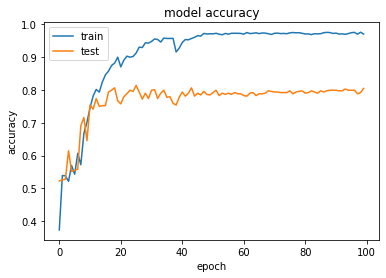

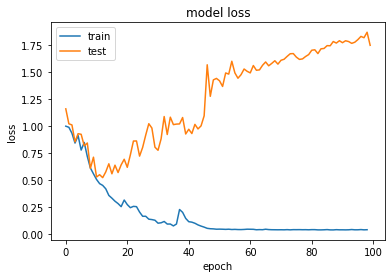

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

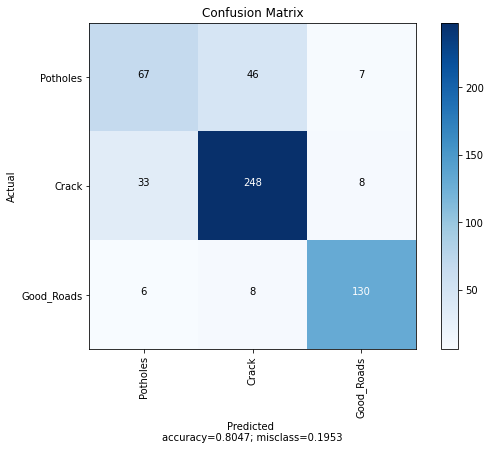

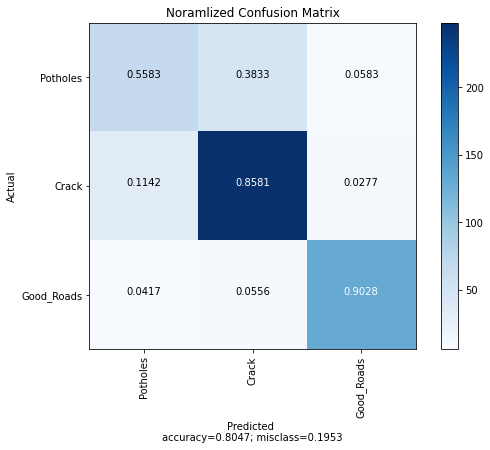

In [28]:
from sklearn import metrics as met
y_Pred = model.predict(test_images32_np)
y_pred = np.argmax(y_Pred, axis=1)
cm = met.confusion_matrix(test_labels_np, y_pred)
# test_labels_np
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = labels_dict_inv,
                      title        = "Confusion Matrix")
plot_confusion_matrix(cm, 
                      normalize    = True,
                      target_names = labels_dict_inv,
                      title        = "Noramlized Confusion Matrix")

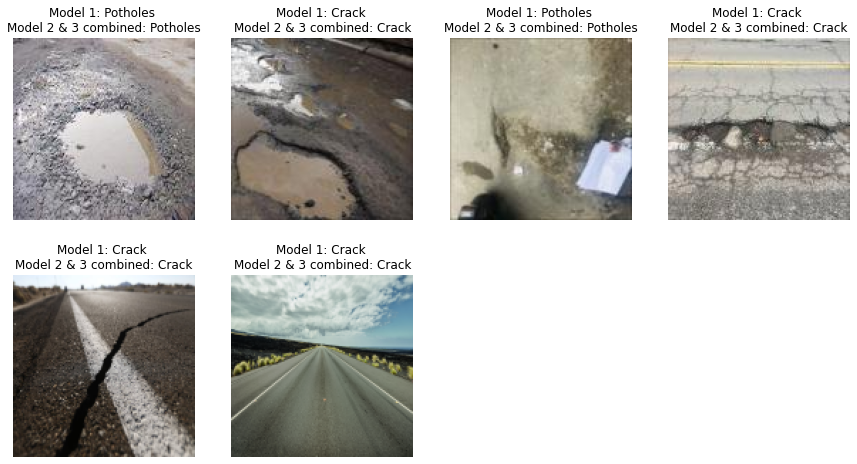

In [33]:
import cv2
plt.figure(figsize=(15, 8))

inference_dir = "/content/gdrive/My Drive/Pothole_images/Test"

file_names = [os.path.join(inference_dir, f) 
              for f in os.listdir(inference_dir) if f.lower().endswith(".ppm") or f.lower().endswith(".jpg")
              or f.lower().endswith(".png") or f.lower().endswith(".jpeg") or f.lower().endswith(".heic")]

for i in range(len(file_names)):
  image = cv2.imread(file_names[i])
  image = image[:,:,::-1]
  image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA)
  img = np.reshape(image,[1,128,128,3])
  img = tf.cast(img, tf.float32) 
  classes_1 = model.predict_classes(img)
  label_1 = labels_dict_inv[classes_1[0]] 

  plt.subplot(len(file_names)/4+1, 4, i+1)  # A grid of 8 rows x 8 columns
  plt.axis('off')
  plt.title("Model 1: %s \nModel 2 & 3 combined: %s" %(label_1, label_1))
  _ = plt.imshow(image)
plt.show()

#XGboost#

In [0]:
from tensorflow.keras import layers, models

In [0]:
# model       = models.Sequential()
inputs      = Input((128,128,3))

zero2d1     = layers.ZeroPadding2D((1,1))(inputs)
conv2d1     = layers.Conv2D(64, (3, 3), activation='relu')(zero2d1)
activation1 = layers.ZeroPadding2D((1,1))(conv2d1)
maxpooling1 = layers.MaxPooling2D((2, 2))(activation1)

zero2d2     = layers.ZeroPadding2D((1,1))(maxpooling1)
conv2d2     = layers.Conv2D(64, (3, 3), activation='relu')(zero2d2)
activation2 = layers.ZeroPadding2D((1,1))(conv2d2)
maxpooling2 = layers.MaxPooling2D((2, 2))(activation2)

zero2d3     = layers.ZeroPadding2D((1,1))(maxpooling2)
conv2d3     = layers.Conv2D(128, (3, 3), activation='relu')(zero2d3)
activation3 = layers.ZeroPadding2D((1,1))(conv2d3)
maxpooling3 = layers.MaxPooling2D((2, 2))(activation3)

zero2d4     = layers.ZeroPadding2D((1,1))(maxpooling3)
conv2d4     = layers.Conv2D(128, (3, 3), activation='relu')(zero2d4)
activation4 = layers.ZeroPadding2D((1,1))(conv2d4)
maxpooling4 = layers.MaxPooling2D((2, 2))(activation4)

flatten = layers.Flatten()(maxpooling4)

dense1 = layers.Dense(4096)(flatten)
activation5 = layers.Activation('relu')(dense1)

dense2 = layers.Dense(1024)(activation5)
activation6 = layers.Activation('relu')(dense2)

dense3 = layers.Dense(3)(activation6)
activation7 = layers.Activation('softmax')(dense3)

model = models.Model(inputs=inputs, outputs=activation7)

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 130, 130, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 130, 130, 64)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 65, 65, 64)        0         
_________________________________________________________________
zero_padding2d_18 (ZeroPaddi (None, 67, 67, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 65, 65, 64)        36928 

In [40]:
from tensorflow.keras.optimizers import RMSprop, Adam

model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
num_epochs = 100
history = model.fit(train_images32_np, train_labels_np, epochs=num_epochs, batch_size=128,
                    validation_data=(test_images32_np,  test_labels_np))

Epoch 1/100
18/18 [==============================] - 4s 215ms/step - loss: 65.0340 - accuracy: 0.4052 - val_loss: 1.1403 - val_accuracy: 0.5298
Epoch 2/100
18/18 [==============================] - 4s 207ms/step - loss: 1.1236 - accuracy: 0.5115 - val_loss: 1.0672 - val_accuracy: 0.5226
Epoch 3/100
18/18 [==============================] - 4s 207ms/step - loss: 1.0312 - accuracy: 0.5129 - val_loss: 1.0776 - val_accuracy: 0.5570
Epoch 4/100
18/18 [==============================] - 4s 207ms/step - loss: 1.0382 - accuracy: 0.5156 - val_loss: 1.1401 - val_accuracy: 0.5226
Epoch 5/100
18/18 [==============================] - 4s 206ms/step - loss: 1.0133 - accuracy: 0.4998 - val_loss: 1.0749 - val_accuracy: 0.5298
Epoch 6/100
18/18 [==============================] - 4s 207ms/step - loss: 1.0017 - accuracy: 0.5373 - val_loss: 1.0060 - val_accuracy: 0.5353
Epoch 7/100
18/18 [==============================] - 4s 207ms/step - loss: 0.9701 - accuracy: 0.5423 - val_loss: 0.9956 - val_accuracy: 0.549

In [0]:
model_dense2_output = models.Model(inputs=inputs, outputs=activation5)

train_feat_map_np = model_dense2_output.predict(train_images32_np)
test_feat_map_np = model_dense2_output.predict(test_images32_np)

In [42]:
print (train_feat_map_np.shape)
print (train_labels_np.reshape((-1, 1)).shape)

(2209, 4096)
(2209, 1)


In [0]:
z = np.concatenate([np.array(train_feat_map_np), np.array(train_labels_np.reshape((-1, 1)))],axis=1)
z = pd.DataFrame(z)
z.to_csv('/content/gdrive/My Drive/Pothole_images/merged_data/train_features.csv',index=False)

z = np.concatenate([np.array(test_feat_map_np), np.array(test_labels_np.reshape((-1, 1)))],axis=1)
z = pd.DataFrame(z)
z.to_csv('/content/gdrive/My Drive/Pothole_images/merged_data/test_features.csv',index=False)

In [44]:
import xgboost
from sklearn import metrics

train = pd.read_csv('/content/gdrive/My Drive/Pothole_images/merged_data/train_features.csv')
train_labels_xg = train['4096'].astype('int')
train_feats_xg = train.drop(['4096'],axis=1)
dataset = xgboost.DMatrix(train_feats_xg, label=train_labels_xg)
watchlist = [(dataset, 'train')]
params = {'max_depth':7, 'eta':0.1, 'silent':1, 'num_class':3,'objective':'multi:softmax' } 
model_xg = xgboost.train(params, dataset, num_boost_round=120, evals=watchlist)

test = pd.read_csv('/content/gdrive/My Drive/Pothole_images/merged_data/test_features.csv')
test_labels_xg = test['4096'].astype('int')
test_feats_xg = test.drop(['4096'],axis=1)

test_x = xgboost.DMatrix(test_feats_xg)
result = model_xg.predict(test_x)

print(metrics.classification_report(test_labels_xg, result))
print(metrics.confusion_matrix(test_labels_xg, result))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-merror:0.083748
[1]	train-merror:0.068357
[2]	train-merror:0.057945
[3]	train-merror:0.055229
[4]	train-merror:0.048891
[5]	train-merror:0.047533
[6]	train-merror:0.044364
[7]	train-merror:0.041195
[8]	train-merror:0.040742
[9]	train-merror:0.038932
[10]	train-merror:0.03531
[11]	train-merror:0.034857
[12]	train-merror:0.033952
[13]	train-merror:0.031689
[14]	train-merror:0.03033
[15]	train-merror:0.029878
[16]	train-merror:0.028972
[17]	train-merror:0.028972
[18]	train-merror:0.02852
[19]	train-merror:0.028067
[20]	train-merror:0.027614
[21]	train-merror:0.027162
[22]	train-merror:0.027162
[23]	train-merror:0.026256
[24]	train-merror:0.026256
[25]	train-merror:0.025804
[26]	train-merror:0.025351
[27]	train-merror:0.025351
[28]	train-merror:0.025351
[29]	train-merror:0.025351
[30]	train-merror:0.025351
[31]	train-merror:0.024898
[32]	train-merror:0.024898
[33]	train-merror:0.024898
[34]	train-merror:0.024898
[35]	train-merror:0.024898
[36]	train-merror:0.024898
[37]	train-mer

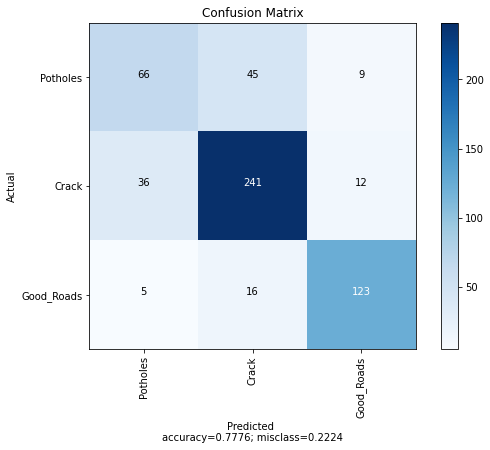

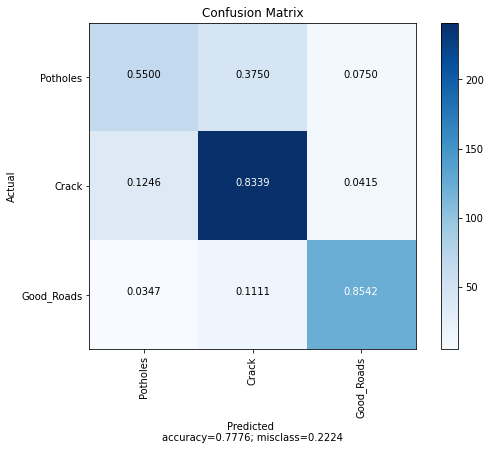

In [45]:
cm = met.confusion_matrix(test_labels_xg, result)
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = labels_dict_inv,
                      title        = "Confusion Matrix")
plot_confusion_matrix(cm, 
                      normalize    = True,
                      target_names = labels_dict_inv,
                      title        = "Confusion Matrix")

#ResNet34

In [57]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 

Using TensorFlow backend.


In [0]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch

In [59]:
path ='/content/drive/My Drive/Pothole_images/merged_data'
tfms = get_transforms(do_flip=False, 
                      flip_vert=True,
                      max_rotate= 20,
                      max_zoom=.1,
                      max_lighting=0.3, max_warp=0.2)

np.random.seed(42)
data_bigger = ImageDataBunch.from_folder(path, train=".",
                                         valid_pct=0.2,
                                         ds_tfms=tfms, #get_transforms(),
                                         size=128,
                                         num_workers=3).normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


IndexError: ignored

#Video Inference

In [0]:
from tensorflow.keras.models import model_from_yaml
from tensorflow.keras.optimizers import RMSprop, Adam

loaded_model_combined = read_saved_model('model_combined_more_data')
loaded_model_good_bad_road = read_saved_model('model_good_bad_road_more_data')
loaded_model_pot_crack = read_saved_model('model_pot_crack_more_data')

Loaded model model_combined_more_data from disk
Loaded model model_good_bad_road_more_data from disk
Loaded model model_pot_crack_more_data from disk


In [0]:
labels_dict = {'Potholes': 0, 'Crack': 1, 'Good_Roads': 2}
labels_dict_inv = ['Potholes', 'Crack', 'Good_Roads']

good_bad_labels_dict = {'Bad_Road': 0, 'Good_Road': 1}
good_bad_labels_dict_inv = ['Bad_Road', 'Good_Road']

pot_crack_labels_dict = {'Potholes': 0, 'Cracks': 1}
pot_crack_labels_dict_inv = ['Potholes', 'Cracks']

In [0]:
import cv2

# out = cv2.VideoWriter('/content/gdrive/My Drive/Pothole_images/output_code.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (128, 128))
cap = cv2.VideoCapture('/content/gdrive/My Drive/Pothole_images/videos /output.mp4')

output_folder = '/content/gdrive/My Drive/Pothole_images/videos_out'
out_file_name = '%s/output_compete_more_data.mp4' %(output_folder)
print(out_file_name)
out = cv2.VideoWriter(out_file_name, cv2.VideoWriter_fourcc(*'MP4V'), 20, (128, 128))

i=-1

import os
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# while(i<100):
while(cap.isOpened()):
  i = i+1
  ret, image = cap.read()

  if ret==False:
    break
  else:
    image = image[:,:,::-1]

    image = cv2.resize(image, (128, 128), interpolation = cv2.INTER_AREA)
    image_cp = image.copy()
    img = np.reshape(image,[1,128,128,3])
    img = tf.cast(img, tf.float32) 

    classes_1 = loaded_model_combined.predict_classes(img)
    label_1 = labels_dict_inv[classes_1[0]]

    classes_2 = loaded_model_good_bad_road.predict_classes(img)

    if (classes_2 == 0):
      classes_2 = loaded_model_pot_crack.predict_classes(img)
      label_2 = pot_crack_labels_dict_inv[classes_2[0]]
    else:
      label_2 = good_bad_labels_dict_inv[classes_2[0]]

    image_cp = cv2.putText(image_cp, label_1, (4, 125), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 0, 0), 1, cv2.LINE_AA) 
    image_cp = cv2.putText(image_cp, label_2, (4, 110), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 0, 0), 1, cv2.LINE_AA) 

    image_cp = image_cp[:,:,::-1]

    out.write(image_cp)

    # out_img_file_name = '%s/img_%s.png' %(output_folder, i)
    # cv2.imwrite(out_img_file_name, image_cp)

cap.release()
out.release()

/content/gdrive/My Drive/Pothole_images/videos_out/output_compete_more_data.mp4
